In [16]:
install.packages("grf")

Warning message:
"package 'grf' is in use and will not be installed"


In [17]:
library(fastDummies)
library(grf)
library(ggplot2)
library(forcats)

## 1. Load Data

In [18]:
url <- "https://raw.githubusercontent.com/d2cml-ai/CausalAI-Course/refs/heads/main/Labs/Assignment/Assignment_5/data/experimental/experimental_control.csv"
data <- read.csv(url)

head(data)


,treat,age,educ,black,hisp,marr,nodegree,re74,re75,re78
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,1,37,11,1,0,1,1,0,0,9930.0459
2,1,22,9,0,1,0,1,0,0,3595.8940
3,1,30,12,1,0,0,0,0,0,24909.4492
4,1,27,11,1,0,0,1,0,0,7506.1460
5,1,33,8,1,0,0,1,0,0,289.7899
6,1,22,9,1,0,0,1,0,0,4056.4939


In [19]:
data <- na.omit(data)



In [20]:
colnames(data)


[1] "treat"    "age"      "educ"     "black"    "hisp"     "marr"    
 [7] "nodegree" "re74"     "re75"     "re78"

In [21]:
summary(data)


     treat             age             educ          black       
 Min.   :0.0000   Min.   :17.00   Min.   : 3.0   Min.   :0.0000  
 1st Qu.:0.0000   1st Qu.:20.00   1st Qu.: 9.0   1st Qu.:1.0000  
 Median :0.0000   Median :24.00   Median :10.0   Median :1.0000  
 Mean   :0.4157   Mean   :25.37   Mean   :10.2   Mean   :0.8337  
 3rd Qu.:1.0000   3rd Qu.:28.00   3rd Qu.:11.0   3rd Qu.:1.0000  
 Max.   :1.0000   Max.   :55.00   Max.   :16.0   Max.   :1.0000  
      hisp              marr           nodegree          re74        
 Min.   :0.00000   Min.   :0.0000   Min.   :0.000   Min.   :    0.0  
 1st Qu.:0.00000   1st Qu.:0.0000   1st Qu.:1.000   1st Qu.:    0.0  
 Median :0.00000   Median :0.0000   Median :1.000   Median :    0.0  
 Mean   :0.08764   Mean   :0.1685   Mean   :0.782   Mean   : 2102.3  
 3rd Qu.:0.00000   3rd Qu.:0.0000   3rd Qu.:1.000   3rd Qu.:  824.4  
 Max.   :1.00000   Max.   :1.0000   Max.   :1.000   Max.   :39570.7  
      re75            re78      
 Min.   :    0 

## 2. ATE

In [22]:
treated <- mean(data$re78[data$treat == 1])
untreated <- mean(data$re78[data$treat == 0])

ATE <- treated - untreated

ATE


[1] 1794.342

The treated people has on average 1794 dollars more of income than the untreated group

## 3. Casual trees

In [23]:
X <- data[, c('age', 'educ', 'black', 'hisp', 'marr', 'nodegree')]

Y <- data[, 're78']

W <- data[, 'treat']


In [24]:
tree <- causal_forest(X, Y, W, num.trees = 1,
                      mtry = ncol(X))

In [25]:
get_tree(tree, 1)

GRF tree object 
Number of training samples: 222 
Variable splits: 
(1) split_variable: age  split_value: 30 
  (2) split_variable: marr  split_value: 0 
    (4) split_variable: age  split_value: 18 
      (6) * num_samples: 21  avg_Y: 5026.72 avg_W: 0.33 
      (7) split_variable: nodegree  split_value: 0 
        (8) * num_samples: 18  avg_Y: 7168.19 avg_W: 0.56 
        (9) split_variable: educ  split_value: 9 
          (10) * num_samples: 13  avg_Y: 4137.71 avg_W: 0.38 
          (11) split_variable: educ  split_value: 10 
            (12) * num_samples: 13  avg_Y: 2919.52 avg_W: 0.38 
            (13) * num_samples: 15  avg_Y: 3816.38 avg_W: 0.27 
    (5) * num_samples: 11  avg_Y: 2351.58 avg_W: 0.27 
  (3) * num_samples: 20  avg_Y: 6214 avg_W: 0.5 

As we can see the splits are made using the age and education. This is an indicator that this are probably the most important variables. The number of leaves are six with signals a potencial heterogenous effect.

## 4. Tree

In [26]:
cf_smalltrees <- causal_forest(X, Y, W,mtry = ncol(X))
tree <- get_tree(cf_smalltrees, 1)
tree

GRF tree object 
Number of training samples: 222 
Variable splits: 
(1) split_variable: age  split_value: 25 
  (2) split_variable: marr  split_value: 0 
    (4) split_variable: educ  split_value: 10 
      (8) split_variable: age  split_value: 20 
        (10) * num_samples: 19  avg_Y: 4403.98 avg_W: 0.42 
        (11) * num_samples: 16  avg_Y: 3355.49 avg_W: 0.25 
      (9) * num_samples: 22  avg_Y: 3770.62 avg_W: 0.27 
    (5) * num_samples: 8  avg_Y: 5686.87 avg_W: 0.62 
  (3) split_variable: educ  split_value: 10 
    (6) * num_samples: 20  avg_Y: 4304.75 avg_W: 0.4 
    (7) * num_samples: 26  avg_Y: 8977.56 avg_W: 0.54 

In [27]:
varimp <- variable_importance(cf_smalltrees)
ranked.vars <- order(varimp, decreasing = TRUE)
importances <- data.frame(variable = colnames(X)[ranked.vars], importance = varimp[ranked.vars])
importances

variable,importance
<chr>,<dbl>
age,0.506148864
educ,0.252048894
marr,0.123139572
nodegree,0.069938353
black,0.046317242
hisp,0.002407074


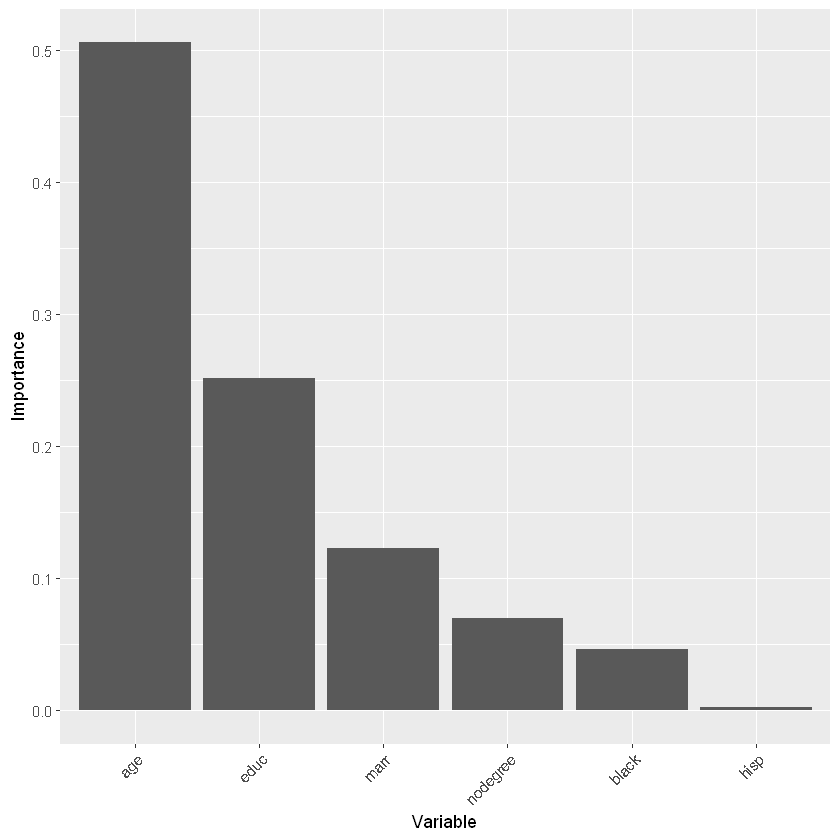

In [28]:
figure <- ggplot(importances,
                 aes(fct_rev(fct_reorder(variable, importance)), importance))
figure + geom_col() +
  scale_x_discrete(guide = guide_axis(angle = 45)) +
  labs(x = "Variable", y = "Importance")

As we can see the most important variable are the ones related to education and age

## 5. Plot heterogenous effect

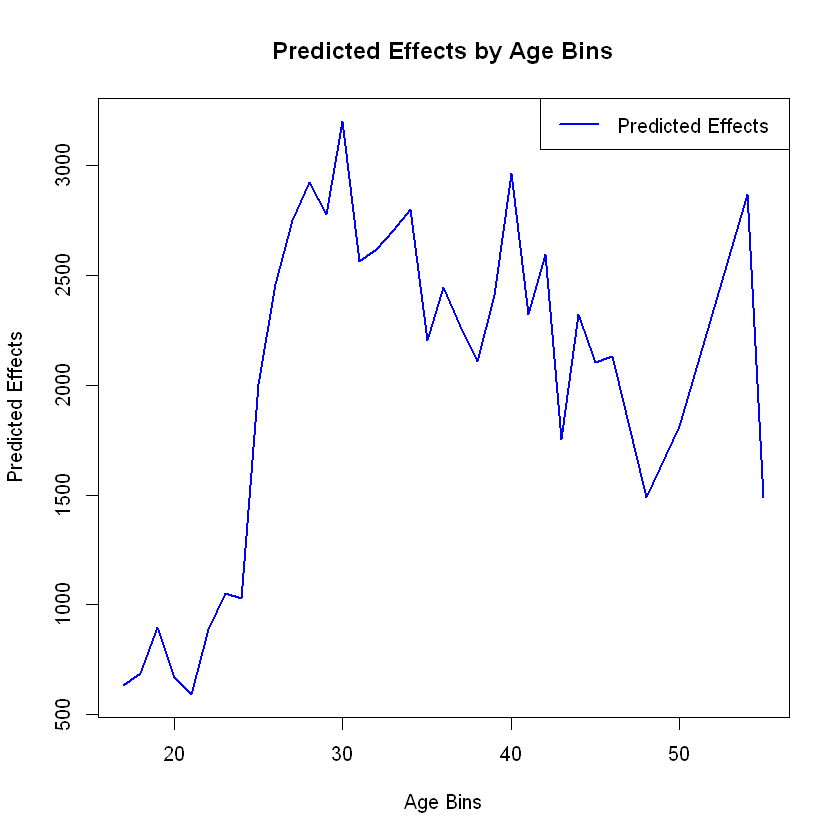

In [29]:
# Crear grupos de edad (bins) con mayor claridad
data$age_bins <- floor(data$age * 2) / 2


data$predicted_effects <- predict(cf_smalltrees, X)$predictions

predicted_effects_bins <- aggregate(predicted_effects ~ age_bins, data = data, mean)

plot(as.numeric(predicted_effects_bins$age_bins), predicted_effects_bins$predicted_effects, 
     type = "l", col = "red", xlab = "Age Bins", ylab = "Predicted Effects", 
     main = "Predicted Effects by Age Bins")

lines(as.numeric(predicted_effects_bins$age_bins), predicted_effects_bins$predicted_effects, col = "blue", lwd = 2)

# Agregar una leyenda
legend("topright", legend = c("Predicted Effects"), col = "blue", lty = 1, lwd = 2)


It has heterogeous effects by age ,especially ,in the first

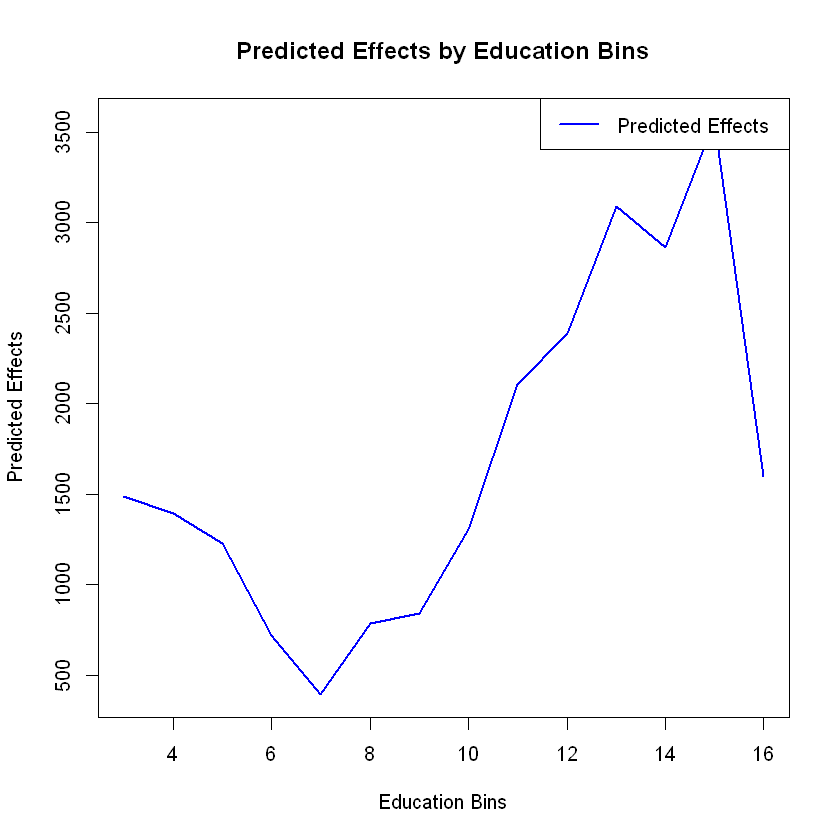

In [30]:
data$educ_bins <- floor(data$educ * 2) / 2

data$predicted_effects <- predict(cf_smalltrees, X)$predictions

predicted_effects_bins <- aggregate(predicted_effects ~ educ_bins, data = data, mean)

bin_labels <- as.numeric(gsub("\\D", "", predicted_effects_bins$educ_bins))

plot(bin_labels, predicted_effects_bins$predicted_effects, 
     type = "l", col = "red", xlab = "Education Bins", ylab = "Predicted Effects", 
     main = "Predicted Effects by Education Bins")

lines(bin_labels, predicted_effects_bins$predicted_effects, col = "blue", lwd = 2)

legend("topright", legend = c("Predicted Effects"), col = "blue", lty = 1, lwd = 2)


The treatment effect is heterogenous by years of education